# Build, test and deploy a Stable Diffusion 2 endpoint

This notebook is a walkthrough of how to take a Stable Diffusion checkpoint from Hugging Face, wrap serving code around it, and create a Docker image which makes the endpoint portable and easy to deploy in different machines. 

The container created will be made available in the Graphcore public registry on Dockerhub and can be used to directly launch a deployment locally or through a Container as a service (CaaS) platform. 

Here, we'll cover:
* Cloning and running up the FastAPI service from this notebook to create a locally hosted endpoint.
* How to access and send requests to the endpoint and receive model output.
* How to build a container image and push it to a registry.
* How to deploy a container and access the model endpoint.

The public model inference images available on Graphcore's Docker Hub have all of the necessary dependencies 'baked in', including executables and model binaries, to make the process of serving up an endpoint launch with minimal warm-up time. The internals of the image are based on the [api-deployment](https://github.com/graphcore/api-deployment) repository. This is designed to be a straightforward example of serving a model with FastAPI and running up a local endpoint. Once you've tested your local endpoint functionality, you can use the same container to launch up a deployment on your target server!

First, install all required dependencies for this notebook:

In [1]:
! # # Buildah installation:https://fabianlee.org/2022/08/02/buildah-installing-buildah-and-podman-on-ubuntu-20-04/
! chmod +x setup.sh
! ./setup.sh > /dev/null
! buildah version

! pip install gradient
! pip install gradio
! pip install matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 25.)
debconf: falling back to frontend: Readline
Version:         1.22.3
Go Version:      go1.15.2
Image Spec:      1.0.1-dev
Runtime Spec:    1.0.2-dev
CNI Spec:        0.4.0
libcni Version:  
image Version:   5.15.2
Git Commit:      
Built:           Thu Jan  1 00:00:00 1970
OS/Arch:         linux/amd64
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 20

## Clone the repo

First, clone the repository containing Stable Diffusion and the files for serving.

In [1]:
! git clone https://github.com/graphcore/stable-diffusion

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 176 (delta 86), reused 124 (delta 50), pack-reused 0
Receiving objects: 100% (176/176), 636.90 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (86/86), done.


The repo contains all of the basic necessities for serving an endpoint using stable diffusion. The `Dockerfile` specifies requirements and builds and runs the Docker container, `src` contains the model and model specific requirements, the FastAPI based endpoint for the model, and the model-independent files for creating the server. `run_server.sh` is a script to launch the server, which can be run directly or runs automatically as part of the docker container. 

In [4]:
! cd stable-diffusion && ls -l

total 56
-rw-r--r-- 1 arsalanu all   576 May  9 11:15 docker-compose.yml
-rw-r--r-- 1 arsalanu all   512 May  9 11:15 Dockerfile
-rw-r--r-- 1 arsalanu all  1066 May  9 11:15 LICENSE
-rw-r--r-- 1 arsalanu all   578 May  9 11:15 ps-deploy-config.yaml
-rw-r--r-- 1 arsalanu all 10335 May  9 11:15 README.md
-rw-r--r-- 1 arsalanu all    40 May  9 11:15 requirements.txt
-rw-r--r-- 1 arsalanu all 19617 May  9 11:15 running_local_endpoint.ipynb
-rwxr-xr-x 1 arsalanu all  2378 May  9 11:15 run_server.sh
drwxr-xr-x 4 arsalanu all   112 May  9 11:15 src
drwxr-xr-x 2 arsalanu all   146 May  9 11:15 utils


## Run a local endpoint

While building the container with all features/executables baked in is needed for launching a public Paperspace deployment, it is not a necessary step if you want to test and run the endpoint locally, as we can do this directly from the repo using the `run_server.sh` script. 

First, install all of the dependencies for serving the model, as well as for the model itself.

In [2]:
! cd stable-diffusion && pip install -r requirements.txt && pip install -r src/models/stable_diffusion_2_txt2img_512/requirements.txt

/bin/bash: line 0: cd: stable-diffusion: No such file or directory


The terminal output when running the server is 'endless', and will block the above cell from ending, so for the purpose of the notebook we run the server as a background process. Once this command is run, the endpoint server will start warming up, performing any necessary preparation required to use the endpoint, such as building the model executables or creating and loading any other required binaries.

In [ ]:
import os
_STORE_SYSTEM = get_ipython().system
get_ipython().system = os.system # Allows running server processes in background in notebook

! cd stable-diffusion && ./run_server.sh &

get_ipython().system = _STORE_SYSTEM # Revert back to original iPython shell after starting server

In either instance, we need to wait for the server to be ready before actually sending any requests to the endpoint. We can wait for the built-in server health-check feature to return a positive status using a simple looping function. For Stable Diffusion, this step may take up to a few minutes. First, import the necessary packages for the function:

In [3]:
import requests
import json
import random
import time

Then we can instantiate our simple function which waits for the readiness status:

```python:
def wait_for_readiness(url):
    while True:
        try:
            response = requests.get(f"{url}/readiness")
            response = response.json()
            if response['message'] == 'Readiness check succeeded.': 
                print(f"Server ready - {response['message']}")
                break
            else:
                print(f"Server waiting - {response['message']}")
                raise Exception
        except Exception as e:
            time.sleep(2)
    return True
```

Next, we time and call the function:

In [ ]:
print("Waiting for readiness...")

warmup_start = time.perf_counter()
ready = wait_for_readiness("http://0.0.0.0:8100")

print(f"Warm up time: {time.perf_counter() - warmup_start}s")

The message should say 'Readiness check succeeded', which means we are ready to start generating images with the model using the live endpoint.

Lets create a dictionary for the parameters to send to the model. This is specific to and defined by the model endpoint that has been created. For Stable Diffusion, we must pass:

* `prompt`: Main body of text describing the image we want to create.
* `random_seed`: Can be used to emulate a deterministic image output from the same prompt each time (we set this to random to observe variation in the image).
* `guidance scale`: Specific to Stable Diffusion, it controls how strongly the generated image will follow the text output.
* `return_json`: Defines whether to return a JSON object in the response or not, to receive an encoded image, we want to set this to True.
* `negative_prompt`: Defines any aspects we don't want to see in the image.
* `num_inference_steps`: The number of sampling steps undertaken by the model, increasing this up to a point should improve the image quality of the generated image, 25-50 steps is a reasonable range for this.

In [4]:
model_params = {
      "prompt": "big red dog",
      "random_seed": random.randint(0,99999999),
      "guidance_scale": 9,
      "return_json": True,
      "negative_prompt": "string",
      "num_inference_steps": 25
}

Next, we can use `requests` to send a POST call to the REST endpoint at the IP address that the endpoint is running on. This will return an image in the response JSON body.

In [5]:
response = requests.post("http://0.0.0.0:8100/stable_diffusion_2_txt2img_512", json=model_params)

if response.status_code != 200:
    print(response.status_code)
    
response = response.json()

Now, the image has been returned in Base64 encoded form within the JSON, we can decode this using the `base64` and `io` libraries to visualise the image. First, we decode the images returned by the model and convert them to PIL RGB images - in this case there is only one image.

In [6]:
from PIL import Image
import base64
import io

images_b64 = [i for i in response['images']]

pil_images = []
for b64_img in images_b64:
    base64bytes = base64.b64decode(b64_img)
    bytesObj = io.BytesIO(base64bytes)
    img = Image.open(bytesObj)
    
    pil_images.append(img)
    
print("Number of images returned: ", len(pil_images))

Number of images returned:  1


Finally, we can view the images with `matplotlib`:

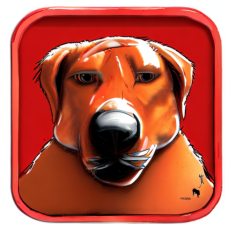

In [7]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(pil_images[0])
plt.show()

## Build Container Image

To have a portable deployment in different platforms, it is recommended to build a container image which includes server files and model that were used previously to run the local endpoint. The container image could be uploaded to a container registry so that deployment would be simply pulling the image and running the endpoint.


### (Optional) Build and upload the image manually

In a local workspace, to build the container we can simply run:
```
docker build -t <local_container_name> .
```
From the root directory of the repository.

In this example, I will show how to use an alternative container manager to build the image with the available user privileges. For this purpose, we can use `buildah` and `podman` to run Docker-equivalent commands on a container. To build the container, we can use `buildah bud` rather than `Docker build` as such:

In [ ]:
! buildah bud -t local-sd2-endpoint stable-diffusion/

Next, tag the image with the name of your Dockerhub registry and the name with which to upload the image.

In [ ]:
username = input(prompt="Enter your Dockerhub username")

In [ ]:
container_name = input(prompt="Enter an image name for the container to be uploaded to your Dockerhub registry")

In [ ]:
! buildah tag local-sd2-endpoint $username/$container_name

Finally, push the built image to your personal Dockerhub registry.

In [ ]:
! buildah push docker.io://$username/$container_name

## (Optional) Create a simple demo frontend for your deployment with **Gradio**

You can create a create an easy frontend demo for your deployment using Gradio. All you need is the URL of your deployment, and a simple function to process the Stable Diffusion 2 input parameters, request the model and decode the output image - the same process we set out for the local endpoint earlier:

This notebook points by default to the locally hosted endpoint. If you would like to run the Gradio app with the launched Paperspace deployment, change the following cell to point to the generated Paperspace deployment URL.

In [8]:
URL = "http://0.0.0.0:8100"

In [9]:
import gradio as gr
import numpy as np

def stable_diffusion_2_inference(prompt, guidance_scale, num_inference_steps):
    model_params = {
      "prompt": prompt,
      "random_seed": random.randint(0,99999999),
      "guidance_scale": guidance_scale,
      "return_json": True,
      "negative_prompt": "string",
      "num_inference_steps": num_inference_steps
    }
    
    response = requests.post(f"{URL}/stable_diffusion_2_txt2img_512", json=model_params)
    response = response.json()
    
    images_b64 = [i for i in response['images']]
    pil_images = []
    for b64_img in images_b64:
        base64bytes = base64.b64decode(b64_img)
        bytesObj = io.BytesIO(base64bytes)
        img = Image.open(bytesObj)

        pil_images.append(img)
    
    return np.array(pil_images[0])

Then, we can initialise the Gradio app to launch a GUI from inside this notebook by defining our inputs, outputs and the processing function:

In [10]:
gr.close_all()
demo = gr.Interface(
    fn=stable_diffusion_2_inference, 
    inputs=[gr.Textbox(value="Ice skating on the moon"),
            gr.Slider(1,50,value=9, step=1, label='Guidance scale'),
            gr.Slider(1,100,value=25, step=1, label='Number of steps')
           ], 
    outputs=gr.Image(shape=(512,512))
    )

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1d608ae9f5249c560a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [12]:
!sudo apt -y update && sudo apt -y install snapd

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease           
Get:3 http://download.opensuse.org/repositories/devel:/kubic:/libcontainers:/stable/xUbuntu_20.04  InRelease [1642 B]
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 1642 B in 7s (247 B/s)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
61 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  apparmor libfuse2 liblzo2-2 squashfs-tools
Suggested packages:
  apparmor-profiles-extra apparmor-utils zenity | kdialog
The following NEW packages will be installed:
  apparmor libfuse2 liblzo2-2 snapd squashfs-tools
0 upgraded, 5 newly installed, 0

In [17]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | \
  sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && \
  echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | \
  sudo tee /etc/apt/sources.list.d/ngrok.list && \
  sudo apt update && sudo apt install ngrok

error: cannot communicate with server: Post http://localhost/v2/snaps/ngrok: dial unix /run/snapd.socket: connect: no such file or directory


In [18]:
!ngrok http 8100

7=ngrok                                                           (Ctrl+C to quit)                                                                                Session Status                connecting                                        Version                       3.3.0                                             Latency                       -                                                 Web Interface                 http://127.0.0.1:4040                                                                                                             Connections                   ttl     opn     rt1     rt5     p50     p90                                     0       0       0.00    0.00    0.00    0.00                                                                                                                                                                                                                                                                                        